In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000L, 8L, 8L), (50000L, 2L, 4L))

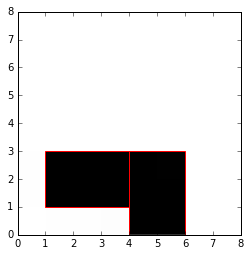

In [4]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [5]:
# Reshape and normalize the data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000L, 64L), 3.1477043194172438e-17, 1.0000000000000004)

In [6]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000L, 8L), 0.28096500000000002, 0.17486042655500986)

In [7]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [8]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

Using Theano backend.


In [9]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print 'Epoch', epoch
    model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + distance(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        if mse_flipped < mse:  # you can also use iou or dist here
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            mses_epoch[i, epoch] = mse_flipped / 2.
            ious_epoch[i, epoch] = iou_flipped / 2.
            dists_epoch[i, epoch] = dist_flipped / 2.
        else:
            mses_epoch[i, epoch] = mse / 2.
            ious_epoch[i, epoch] = iou / 2.
            dists_epoch[i, epoch] = dist / 2.
            
    print 'Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.)
    print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
    print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
    print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
    print

Epoch 0
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0891 - val_loss: 0.0198
Flipped 19332.0 training samples (48.33 %)
Mean IOU: 0.17421432926
Mean dist: 0.202194946413
Mean mse: 0.00870554196174

Epoch 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0188 - val_loss: 0.0188
Flipped 7403.0 training samples (18.5075 %)
Mean IOU: 0.201610919572
Mean dist: 0.179289382942
Mean mse: 0.00696734712723

Epoch 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0150 - val_loss: 0.0204
Flipped 4240.0 training samples (10.6 %)
Mean IOU: 0.251106918999
Mean dist: 0.153800096666
Mean mse: 0.00559663701382

Epoch 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
3s - loss: 0.0130 - val_loss: 0.0212
Flipped 2280.0 training samples (5.7 %)
Mean IOU: 0.277501980239
Mean dist: 0.141010581968
Mean mse: 0.00496034980357

Epoch 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0119 - val_loss:

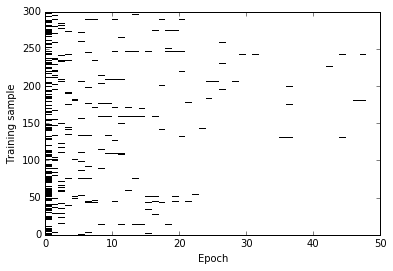

In [10]:
# Show flippings for a few training samples.
plt.pcolor(flipped[:300], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

# plt.savefig('plots/bw-two-rectangles_flips.png', dpi=300)

(0, 1)

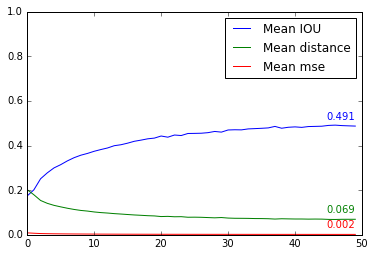

In [11]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')

plt.legend()
plt.ylim(0, 1)

In [12]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000L, 2L, 4L)

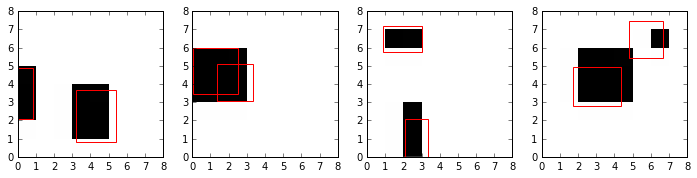

In [14]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))

# plt.savefig('plots/bw-two-rectangles_with-flipping.png', dpi=300)